# Multipoint ICMEs in the Solar Orbiter era

Notebook for the results and plots shown in the paper Möstl et al. 2021 ApJ (in prep.).

https://github.com/helioforecast/Papers/tree/master/Moestl2021_multipoint

Authors: C. Möstl, IWF Graz, Austria https://twitter.com/chrisoutofspace 

**last update 2021 August 20**

To run this code, a conda environment is needed, dependencies are listed under environment.yml, and pip in requirements.txt. Plots are saved in folder "plots" as png and pdf. 


**Data sources**

The ICME catalog ICMECATv2.0, included in folder "icmecat". The latest versions can be downloaded from https://doi.org/10.6084/m9.figshare.6356420 or https://helioforecast.space/icmecat

The CME arrival catalog (based on STEREO heliospheric imager observations) ARRCATv2.0 (updated 2021-Apr-23) is included in the folder "data". Latest versions can be obtained from either: https://helioforecast.space/arrcat or https://doi.org/10.6084/m9.figshare.12271292 

If needed, in situ data needs to be downloaded into a directory defined in config.py from this figshare repository: https://doi.org/10.6084/m9.figshare.11973693


---

**MIT LICENSE**

Copyright 2021, Christian Moestl

Permission is hereby granted, free of charge, to any person obtaining a copy of this 
software and associated documentation files (the "Software"), to deal in the Software
without restriction, including without limitation the rights to use, copy, modify, 
merge, publish, distribute, sublicense, and/or sell copies of the Software, and to 
permit persons to whom the Software is furnished to do so, subject to the following 
conditions:

The above copyright notice and this permission notice shall be included in all copies 
or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, 
INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A
PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT 
HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF 
CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE 
OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.





In [1]:
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc
import seaborn as sns
import numpy as np
import scipy.io
from scipy import stats
import sys
from datetime import timedelta
import time
import pickle
import os
import copy
import urllib
import json
import warnings
import importlib

import heliocats.data as hd

import sunpy
import sunpy.time
from sunpy.time import parse_time

import heliopy.spice as spice
import heliopy.data.spice as spicedata

import astropy
import astropy.constants as const

#our own packages
import py3dcore
import heliosat

#where the 6 in situ data files are located is read from input.py
#as data_path=....
from config import data_path

#Convert this notebook to a script with jupyter nbconvert --to script cme_rate.ipynb
os.system('jupyter nbconvert --to script cme_sig.ipynb')    

#%matplotlib inline
#matplotlib.use('Qt5Agg')
#matplotlib.use('Agg')
#warnings.filterwarnings('ignore') # some numpy mean-of-empty-slice runtime warnings

########### make directories first time
resdir='plots'
if os.path.isdir(resdir) == False: os.mkdir(resdir)

datadir='data'
if os.path.isdir(datadir) == False: os.mkdir(datadir)

plt.rcParams["figure.figsize"] = (15,8)
plt.close('all')

#constants: 
#solar radius
Rs_in_AU=float(const.R_sun/const.au)
#define AU in km
AU_in_km=const.au.value/1e3


print('sunpy:',sunpy.__version__)
print('astropy:',astropy.__version__)

print('done')

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.
sunpy: 1.1.0
astropy: 4.0
done


In [2]:
########### load ICMECAT v2.0, made with icmecat.py or ipynb
file='icmecat/HELCATS_ICMECAT_v20_pandas.p'
print()
print('loaded ', file)
print()
print('Keys (parameters) in this pandas data frame are:')

[ic,h,p]=pickle.load(open(file, "rb" ) )  
print(ic.keys())
print()


loaded  icmecat/HELCATS_ICMECAT_v20_pandas.p

Keys (parameters) in this pandas data frame are:
Index(['icmecat_id', 'sc_insitu', 'icme_start_time', 'mo_start_time',
       'mo_end_time', 'mo_sc_heliodistance', 'mo_sc_long_heeq',
       'mo_sc_lat_heeq', 'icme_duration', 'icme_bmax', 'icme_bmean',
       'icme_bstd', 'icme_speed_mean', 'icme_speed_std', 'mo_duration',
       'mo_bmax', 'mo_bmean', 'mo_bstd', 'mo_bzmean', 'mo_bzmin', 'mo_bzstd',
       'mo_bymean', 'mo_bystd', 'mo_speed_mean', 'mo_speed_std',
       'mo_expansion_speed', 'mo_pdyn_mean', 'mo_pdyn_std', 'mo_density_mean',
       'mo_density_std', 'mo_temperature_mean', 'mo_temperature_std',
       'sheath_speed_mean', 'sheath_speed_std', 'sheath_density_mean',
       'sheath_density_std', 'sheath_pdyn_mean', 'sheath_pdyn_std'],
      dtype='object')



In [3]:
ic

,icmecat_id,sc_insitu,icme_start_time,mo_start_time,mo_end_time,mo_sc_heliodistance,mo_sc_long_heeq,mo_sc_lat_heeq,icme_duration,icme_bmax,...,mo_density_mean,mo_density_std,mo_temperature_mean,mo_temperature_std,sheath_speed_mean,sheath_speed_std,sheath_density_mean,sheath_density_std,sheath_pdyn_mean,sheath_pdyn_std
0,ICME_STEREO_A_MOESTL_20210809_01,STEREO-A,2021-08-09 17:28:00,2021-08-09 23:18:00,2021-08-10 08:36:00,0.9572,-43.69,2.32,15.13,10.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ICME_Wind_MOESTL_20210705_01,Wind,2021-07-05 00:36:00,2021-07-05 07:12:00,2021-07-06 00:08:00,1.0062,-0.20,3.39,23.53,8.2,...,8.7,3.1,62046.8,26220.5,344.5,8.0,11.6,1.7,2.3,0.4
2,ICME_STEREO_A_MOESTL_20210619_01,STEREO-A,2021-06-19 20:44:00,2021-06-20 01:30:00,2021-06-21 06:29:00,0.9615,-48.30,-4.21,33.75,11.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ICME_Wind_MOESTL_20210611_01,Wind,2021-06-11 00:42:00,2021-06-11 00:42:00,2021-06-11 15:00:00,1.0061,-0.25,0.55,14.30,8.3,...,6.7,1.2,26737.0,10872.8,NaN,NaN,NaN,NaN,NaN,NaN
4,ICME_Wind_MOESTL_20210526_01,Wind,2021-05-26 11:44:00,2021-05-26 21:20:00,2021-05-29 04:32:00,1.0044,-0.19,-1.31,64.80,16.3,...,6.4,6.3,97617.5,34569.3,366.1,14.7,24.3,10.2,5.4,2.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811,ICME_VEX_SGOOD_20070213_01,VEX,2007-02-13 14:40:00,2007-02-13 14:40:00,2007-02-14 09:33:00,0.7245,-117.25,2.83,18.88,19.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
812,ICME_Wind_NASA_20070115_01,Wind,2007-01-15 20:49:00,2007-01-15 20:49:00,2007-01-16 04:45:00,0.9731,0.15,-4.57,7.93,10.4,...,4.1,1.4,97358.1,37602.1,NaN,NaN,NaN,NaN,NaN,NaN
813,ICME_STEREO_B_JIAN_20070114_01,STEREO-B,2007-01-14 12:24:00,2007-01-14 13:59:00,2007-01-15 07:37:00,0.9791,0.02,-4.52,19.22,14.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
814,ICME_STEREO_A_JIAN_20070114_01,STEREO-A,2007-01-14 12:11:00,2007-01-14 14:39:00,2007-01-15 07:34:00,0.9727,0.26,-4.61,19.38,14.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#load HIGeoCAT
from heliocats import cats as hc
importlib.reload(hc) #reload again while debugging 

#https://www.helcats-fp7.eu/
#LOAD HELCATS HIGeoCAT
url_higeocat='https://www.helcats-fp7.eu/catalogues/data/HCME_WP3_V06.vot'

try: urllib.request.urlretrieve(url_higeocat,'data/HCME_WP3_V06.vot')
except urllib.error.URLError as e:
    print('higeocat not loaded')

higeocat=hc.load_higeocat_vot('data/HCME_WP3_V06.vot')
higeocat_time=parse_time(higeocat['Date']).datetime    
higeocat_t0=parse_time(higeocat['SSE Launch']).datetime   #backprojected launch time

sse_speed=higeocat['SSE Speed']
sse_lon=higeocat['SSE HEEQ Long']
sse_lat=higeocat['SSE HEEQ Lat']
higeocat_name=np.array(higeocat['SC'].astype(str))
higeocat_id=np.array(higeocat['ID'].astype(str))



print('done')

done


In [5]:
#CACTUS
url_cactus='https://wwwbis.sidc.be/cactus/catalog/LASCO/2_5_0/cmecat_combo.sav'

try: urllib.request.urlretrieve(url_cactus,'data/LASCO_CME/cmecat_combo.sav')
except urllib.error.URLError as e:
    print('lasco cme not loaded')


#LASCO CME catalog 
url_lasco='https://cdaw.gsfc.nasa.gov/CME_list/UNIVERSAL/text_ver/univ_all.txt'

try: urllib.request.urlretrieve(url_lasco,'data/LASCO_CME/univ_all.txt')
except urllib.error.URLError as e:
    print('lasco cme not loaded')

In [6]:
#read lasco catalog

la=np.genfromtxt('data/LASCO_CME/univ_all.txt',dtype=(str), usecols=[0,1,2,3,4,5,6,7,8,9,10,11],skip_header=4)

la_time=[]
cpa=np.zeros(len(la))
width=np.zeros(len(la))
speedlin=np.zeros(len(la))

# ========= SOHO/LASCO CME CATALOG==========      LAST UPDATED: 2021/08/09 13:39
# Date       Time     Central  Width  Linear   2nd order speed      Accel     Mass      Kinetic    MPA   Remarks
#                        PA           Speed  initial final   20R                        Energy                 

for i in np.arange(0,len(la)):
    #convert time from string to datetime
    la_time.append(parse_time(la[i][0]+' '+la[i][1]).isot)
    
    
    if la[i][2]=='Halo': 
        cpa[i]=360
    else:
        cpa[i]=float(la[i][2])

    width[i]=int(la[i][3])
    
    if la[i][4]=='----':
        speedlin[i]=np.nan
    else:
        speedlin[i]=int(la[i][4])

#print(la_time)
#print(cpa)
#print(width)
#print(speedlin)

data=np.vstack([parse_time(la_time).datetime,cpa,width,speedlin])
# Create the pandas DataFrame
ldf = pd.DataFrame(data.transpose(), columns = ['time','cpa','width','speed'])
                                   

### load WSA/THUX solar wind speed data

In [7]:
wsa_all=np.loadtxt('data/thux/wsa-planets-missions-cr2047-cr2246.txt',skiprows=1)

#file looks like
#Time[matlab]	vEarth	vMercury	vVenus	vMars	vBepi	vPSP	vSOLO	vSTEREOA	vSTEREOB			

#need to convert matlab time to matplotlib time
wsa_all_datetime=[None]*len(wsa_all)
for p in np.arange(len(wsa_all)):
        wsa_all_datetime[p]= datetime.datetime.fromordinal(wsa_all[p,0].astype(int) ) + \
        datetime.timedelta(days=wsa_all[p,0]%1) - datetime.timedelta(days = 366) 


#make recarray
thux=np.zeros(np.size(wsa_all_datetime),dtype=[('time',object),('wind', float),('bepi', float),\
            ('psp', float),('solo', float),('sta', float)] )   

#convert to recarray
thux = thux.view(np.recarray)  
thux.time=wsa_all_datetime
thux.wind=wsa_all[:,1]
thux.bepi=wsa_all[:,5]
thux.psp=wsa_all[:,6]
thux.solo=wsa_all[:,7]
thux.sta=wsa_all[:,8]                                       

print('done')

done


## Create multipoint CME catalog

In [69]:
#define Events from ICMECAT, add HIGEOcat if connection to in situ is evident
#HI arrival within +/- 24 hours at 1 AU

#add identified events from  HIGEOCAT and/or CACTUS


#get indices in ICMECAT and HIGEOCAT
def get_cat_ind(event_list,event_type):
    event_ind=[]
    for i in np.arange(len(event_list)):        
        
        #LASCO
        #if event_type[i]==2:
        #    event_ind.append(np.where(ldf.time==event_list[i])[0][0])
            
        #HICAT    
        if event_type[i]==0:
            #print('hicat')
            event_ind.append(np.where(higeocat_id==event_list[i])[0][0])
            
        #ICMECAT    
        if event_type[i]==1:            
            #print('icmecat')
            event_ind.append(np.where(ic.icmecat_id==event_list[i])[0][0])
            
    return event_ind    


event_all=[]
event_all_ind=[]
event_all_type=[]



#### 1
#time in lasco cat - get from online catalog
cme_start=datetime.datetime(2020,4,15,0,18,20)
event_ind_lasco=np.where(ldf.time==cme_start)[0][0]
l_id=parse_time(cme_start).iso
print('Event 1 cpa, width, speed,', ldf.cpa[event_ind_lasco],ldf.width[event_ind_lasco], ldf.speed[event_ind_lasco])


event=['HCME_A__20200415_01',
       'ICME_SOLO_MOESTL_20200419_01', 
       'ICME_Wind_MOESTL_20200420_01', 
       'ICME_BEPI_MOESTL_20200420_01']
#0 for imaging, 1 for in situ
event_type=[0,1,1,1]
event_ind=get_cat_ind(event,event_type)
event_all.extend(event)
event_all_ind.extend(event_ind)
event_all_type.extend(event_type)

### 2
event=['HCME_A__20200526_01',
        'ICME_SOLO_MOESTL_20200528_01', 
        'ICME_Wind_MOESTL_20200529_01', 
        'ICME_BEPI_MOESTL_20200529_01']
#0 for imaging, 1 for in situ
event_type=[0,1,1,1]
event_ind=get_cat_ind(event,event_type)
event_all.extend(event)
event_all_ind.extend(event_ind)
event_all_type.extend(event_type)


### 3
event=['HCME_A__20200527_01',
       'ICME_STEREO_A_MOESTL_20200603_01' ]
#0 for imaging, 1 for in situ
event_type=[0,1]
event_ind=get_cat_ind(event,event_type)
event_all.extend(event)
event_all_ind.extend(event_ind)
event_all_type.extend(event_type)




#### 4
event=['HCME_A__20200623_01',
        'ICME_PSP_MOESTL_20200625_01', 
        'ICME_BEPI_MOESTL_20200629_01', 
        'ICME_Wind_MOESTL_20200701_01']
#0 for imaging, 1 for in situ
event_type=[0,1,1,1]
event_ind=get_cat_ind(event,event_type)
event_all.extend(event)
event_all_ind.extend(event_ind)
event_all_type.extend(event_type)

### 5
event=['HCME_A__20200706_01',
        'ICME_STEREO_A_MOESTL_20200709_01']
#0 for imaging, 1 for in situ
event_type=[0,1]
event_ind=get_cat_ind(event,event_type)
event_all.extend(event)
event_all_ind.extend(event_ind)
event_all_type.extend(event_type)



### 6
event=['HCME_A__20200709_01',
        'ICME_Wind_MOESTL_20200713_01']
#0 for imaging, 1 for in situ
event_type=[0,1]
event_ind=get_cat_ind(event,event_type)
event_all.extend(event)
event_all_ind.extend(event_ind)
event_all_type.extend(event_type)



### 7
event=['HCME_A__20200816_01',
       'ICME_STEREO_A_MOESTL_20200819_01']
#0 for imaging, 1 for in situ
event_type=[0,1]
event_ind=get_cat_ind(event,event_type)
event_all.extend(event)
event_all_ind.extend(event_ind)
event_all_type.extend(event_type)




### 8
event=['HCME_A__20200908_01',
       'ICME_PSP_MOESTL_20200912_01']
#0 for imaging, 1 for in situ
event_type=[0,1]
event_ind=get_cat_ind(event,event_type)
event_all.extend(event)
event_all_ind.extend(event_ind)
event_all_type.extend(event_type)



### 9
event=['HCME_A__20200930_01',
        'ICME_Wind_MOESTL_20201005_01' ]
#0 for imaging, 1 for in situ
event_type=[0,1]
event_ind=get_cat_ind(event,event_type)
event_all.extend(event)
event_all_ind.extend(event_ind)
event_all_type.extend(event_type)





### 10  **MERGER
event=['HCME_A__20201006_01',
       'ICME_BEPI_MOESTL_20201008_01',
       'ICME_BEPI_MOESTL_20201010_01']
#0 for imaging, 1 for in situ
event_type=[0,1,1]
event_ind=get_cat_ind(event,event_type)
event_all.extend(event)
event_all_ind.extend(event_ind)
event_all_type.extend(event_type)





### 11
event=['HCME_A__20201026_01',
       'ICME_Wind_MOESTL_20201101_01']
#0 for imaging, 1 for in situ
event_type=[0,1]
event_ind=get_cat_ind(event,event_type)
event_all.extend(event)
event_all_ind.extend(event_ind)
event_all_type.extend(event_type)




#### 12
#time in lasco cat - get from online catalog
cme_start=datetime.datetime(2020,11,29,13,25,49)
event_ind_lasco=np.where(ldf.time==cme_start)[0][0]
l_id=parse_time(cme_start).iso

print('Event 12 cpa, width, speed,', ldf.cpa[event_ind_lasco],ldf.width[event_ind_lasco], ldf.speed[event_ind_lasco])

event=[ 'ICME_PSP_MOESTL_20201201_01',
        'ICME_STEREO_A_MOESTL_20201201_01'        ]
#0 for imaging, 1 for in situ
event_type=[1,1]
event_ind=get_cat_ind(event,event_type)
event_all.extend(event)
event_all_ind.extend(event_ind)
event_all_type.extend(event_type)




#####13  * *MERGER
event=['HCME_A__20201129_01',
       'HCME_A__20201201_01',
        'ICME_STEREO_A_MOESTL_20201203_01' ]#****add 2nd ICME shortly before this one
#0 for imaging, 1 for in situ
event_type=[0,0,1]
event_ind=get_cat_ind(event,event_type)
event_all.extend(event)
event_all_ind.extend(event_ind)
event_all_type.extend(event_type)


#####14
event=['HCME_A__20210211_01',
        'ICME_Wind_MOESTL_20210215_01' ]
#0 for imaging, 1 for in situ
event_type=[0,1]
event_ind=get_cat_ind(event,event_type)
event_all.extend(event)
event_all_ind.extend(event_ind)
event_all_type.extend(event_type)


#####15
event=['HCME_A__20210220_01',
       'ICME_STEREO_A_MOESTL_20210223_01',
       'ICME_Wind_MOESTL_20210224_01']
#0 for imaging, 1 for in situ
event_type=[0,1,1]
event_ind=get_cat_ind(event,event_type)
event_all.extend(event)
event_all_ind.extend(event_ind)
event_all_type.extend(event_type)


#####16
event=['HCME_A__20210322_01',
       'ICME_Wind_MOESTL_20210326_01']
#0 for imaging, 1 for in situ
event_type=[0,1]
event_ind=get_cat_ind(event,event_type)
event_all.extend(event)
event_all_ind.extend(event_ind)
event_all_type.extend(event_type)


#####17
event=['HCME_A__20210331_01',
       'ICME_Wind_MOESTL_20210404_01',
       'ICME_STEREO_A_MOESTL_20210406_01',
       ]
#0 for imaging, 1 for in situ
event_type=[0,1,1]
event_ind=get_cat_ind(event,event_type)
event_all.extend(event)
event_all_ind.extend(event_ind)
event_all_type.extend(event_type)




#######################************** NEW EVENTS NOT IN MÖSTL ET AL 2021 **********

#####18
#event=['HCME_A__20210410_01',
#       'ICME_Wind_MOESTL_20210415_01',
#       ]
#0 for imaging, 1 for in situ
#event_type=[0,1]
#event_ind=get_cat_ind(event,event_type)
#event_all.extend(event)
#event_all_ind.extend(event_ind)
#event_all_type.extend(event_type)












########################################




#make event numbering array (1,1,1,2,2,2,...)
event_numbering=[1,1,1,1,2,2,2,2,3,3, 4,4,4,4, 5,5,  6,6,   7,7 ,
                 8,8, 9,9, 10,10,10, 11,11,  12,12,  13,13,13,  14,14,  15,15,15,  16,16,  17,17, 17]


#### build up data frame
data=[]
for i in np.arange(0,len(event_all),1):
    
    #HI
    if event_all_type[i]==0:
        
        #HI time when it appears in HI1?
        hi_time=parse_time(higeocat['Date'][event_all_ind[i]].decode("utf-8")).datetime
        
        ############# generate STEREO-A position
        spice.furnish(spicedata.get_kernel('stereo_a'))
        sta=spice.Trajectory('-234')  
        sta.generate_positions([hi_time,hi_time],'Sun','HEEQ')  
        sta.change_units(astropy.units.AU)  
        [sta_r, sta_lat, sta_lon]=hd.cart2sphere(sta.x,sta.y,sta.z)
        #print('STEREO-A') 
        #print(sta_r[0])
        #print(np.rad2deg(sta_lon[0]))


        data.append([event_numbering[i], hi_time, 
                    'HIA',
                     np.round(sta_r[0],3),
                     np.round(np.rad2deg(sta_lon[0]),1),
                    sse_lon[event_all_ind[i]],
                    sse_speed[event_all_ind[i]],
                     '-',
                     '-',
                    higeocat_id[event_all_ind[i]] 
                    ] )


    #HI    
    #in situ 
    if event_all_type[i]==1:
        
        #to avoid NaN in the table
        speed=np.rint(ic.icme_speed_mean[event_all_ind[i]])
        #print(speed)
        if np.isnan(speed): speed='-'


        data.append([event_numbering[i], ic.icme_start_time[event_all_ind[i]], 
                    ic.sc_insitu[event_all_ind[i]],
                    np.round(ic.mo_sc_heliodistance[event_all_ind[i]],3),                     
                    np.round(ic.mo_sc_long_heeq[event_all_ind[i]],1),    
                    '-',    
                    speed, 
                    ic.mo_bmax[event_all_ind[i]],
                    ic.mo_bzmin[event_all_ind[i]],                    
                    ic.icmecat_id[event_all_ind[i]]  
                    ] )
  
 
    
  
# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ['event', 'event_start_time','spacecraft','sc_heliodistance','sc_heeq_lon','cme_heeq_lon','speed','mo_bmax','mo_bzmin','id'] )

#df= df.drop(columns='id')

df = df.reset_index(drop=True)

df2=copy.deepcopy(df)
#make latex table for paper Moestl et al. 2021 - remove id and all after 2021 March 31
df2= df2.drop(columns='id')
#df2=df2.drop([44,45 ])
df2.to_latex(buf='lineups/table_insitu.txt',index=False)  
    
# print dataframe.
df

Event 1 cpa, width, speed, 276.0 104.0 80.0
Event 12 cpa, width, speed, 360.0 360.0 2077.0


,event,event_start_time,spacecraft,sc_heliodistance,sc_heeq_lon,cme_heeq_lon,speed,mo_bmax,mo_bzmin,id
0,1,2020-04-15 20:49:00,HIA,0.967,-75.4,-6,339,-,-,HCME_A__20200415_01
1,1,2020-04-19 05:06:00,SolarOrbiter,0.808,-4.0,-,-,21.2,-19.2,ICME_SOLO_MOESTL_20200419_01
2,1,2020-04-20 01:34:00,Wind,0.996,0.2,-,346,16.2,-15.1,ICME_Wind_MOESTL_20200420_01
3,1,2020-04-20 03:09:00,BepiColombo,1.011,-1.3,-,-,16.1,-14.4,ICME_BEPI_MOESTL_20200420_01
4,2,2020-05-26 01:29:00,HIA,0.966,-72.3,36,497,-,-,HCME_A__20200526_01
5,2,2020-05-28 12:45:00,SolarOrbiter,0.564,28.2,-,-,28.2,-26.6,ICME_SOLO_MOESTL_20200528_01
6,2,2020-05-29 21:20:00,Wind,1.005,-0.2,-,350,14.5,-12.4,ICME_Wind_MOESTL_20200529_01
7,2,2020-05-29 15:27:00,BepiColombo,0.977,-5.2,-,-,13.1,-11.5,ICME_BEPI_MOESTL_20200529_01
8,3,2020-05-27 04:49:00,HIA,0.966,-72.2,-47,315,-,-,HCME_A__20200527_01
9,3,2020-06-03 07:54:00,STEREO-A,0.965,-71.5,-,373,9.9,-4.6,ICME_STEREO_A_MOESTL_20200603_01


## header

In [72]:
#save header and parameters as text file and prepare for html website
header='HELIO4CAST Multipoint ICME catalog v1.0 \n\n\
This is the HELIO4CAST multipoint interplanetary coronal mass ejection (ICME) catalog. \n\
This is version 1.0, to be released in September 2021. doi: 10.6084/m9.figshare.15134745 \n\n\
Rules: If results are produced with this catalog for peer-reviewed scientific publications,\n\
please contact christian.moestl@oeaw.ac.at for possible co-authorship. \n\
The reference for this catalog is Moestl et al. 2021 (in preparation).  \n\n\
The catalog is available as a python pandas dataframe (pickle), json, csv, xlsx, txt, at \n\
https://helioforecast.space/lineups and https://doi.org/10.6084/m9.figshare.15134745 . \n\n\
Number of events: '+str(df.at[len(df)-1,'event'])+' \n\
ICME observatories: Solar Orbiter, Parker Solar Probe (PSP), BepiColombo, Wind, STEREO-A.   \n\
Time range: April 2020 - April 2021. \n\n\
Authors: Christian Moestl, Andreas J. Weiss, Rachel L. Bailey, Martin A. Reiss, \n\
Space Research Institute, Austrian Academy of Sciences, Graz, Austria.\n\
Barnes, J. A. Davies, R. A. Harrison, RAL Space, UK. \n\n\
The python source code for producing this catalog is available at https://github.com/cmoestl/heliocats lineups.ipynb\n\n\
Each event has unique identifier either from the HELIO4CAST ICMECAT or the HELCATS HIGeoCAT. \n\n\
Comments: \n\n\
- Spacecraft positions are given in Heliocentric Earth Equatorial Coordinates (HEEQ) coordinates. \n\n\
- The coordinate system for the Bz magnetic field components is SCEQ, except for Wind (HEEQ, which is the equivalent for SCEQ for Earth). \n\
        Definition of SpaceCraft Equatorial Coordinates (SCEQ): \n\
        Z is the solar rotation axis. \n\
        Y is the cross product of Z and R, with R being the vector that points from the Sun to the spacecraft.\n\
        X completes the right handed triad (and points away from the Sun). \n\
This system is thus like HEEQ but centered on the respective in situ spacecraft, so the SCEQ X and Y \n\
base vectors are rotated by the HEEQ longitude of the in situ spacecraft from HEEQ X and Y.\n\
The Y vector is similar to the T vector in an RTN system for each spacecraft, but the X and Z vectors \n\
are rotated around Y compared to an RTN system. The differences between RTN and SCEQ for spacecraft within \n\
a few degrees of the solar equatorial plane are very small (within a few 0.1 nT usually).\n\
We choose SCEQ for the advantage that a comparison of the data of multipoint CME events \n\
and comparisons to simulations are simpler because there is always a similar reference plane (the solar equatorial plane).\n\n\''


parameters='Parameters:\n\
01: event: To which multipoint event the row belongs to, unit: integer. \n\
02: event_start_time: For in situ spacecraft, similar to icme_start_time in the ICMECAT. For STEREO-A-HI (HIA), its the sse_launch_time from HIGeoCAT. unit: UTC. \n\
03: spacecraft: HIA if the entry refers to observations from STEREO-A-HI, otherwise the in situ observing spacecraft. unit: string. \n\
04: sc_heliodistance: Heliocentric distance of the spacecraft at event_start_time. unit: AU.\n\
05: sc_long_heeq: Heliospheric longitude of the spacecraft at event_start_time, range [-180,180]. unit: degree (HEEQ).\n\
06: cme_long_heeq: CME longitude, derived from SSEF30 modeling with STEREO-A-HI, range [-180,180]. unit: degree (HEEQ).\n\
07: speed: For in situ observations, the speed over the whole ICME interval (icme_speed_mean in ICMECAT). For HIA, the speed derived from SSEF30 modeling in HIGeoCAT. unit: km/s.\n\
08: mo_bmax: Only for in situ observations, maximum total magnetic field in the magnetic obstacle interval (mo_start_time to mo_end_time). unit: nT.\n\
09: mo_bzmin: Only for in situ observations, minimum magnetic field Bz component in the magnetic obstacle. unit: nT.\n\
10: id: the id from either the ICMECAT or HIGeoCAT, allowing to look up the event directly in these other catalogs. \n\n\n'



print(header)
print()
print(parameters)


#make header file
file='lineups/HELIO4CAST_multipoint_v10_header.txt'
with open(file, "w") as text_file:
    text_file.write(header)
    text_file.write(parameters)
print()    
print('header saved as '+file)
print()    

#Convert to html regarding line breaks, paragraph beginning and spaces
header_spaces=header.replace(" ", "&nbsp;")
header_html= "<p>" +header_spaces.replace('\n', '<br>')+ "</p>" 
parameters_spaces=parameters.replace(" ", "&nbsp;")
parameters_html= "<p>" +parameters.replace('\n', '<br>')+ "</p>"
print('header converted to HTML')
print()    
print()    

HELIO4CAST Multipoint ICME catalog v1.0 

This is the HELIO4CAST multipoint interplanetary coronal mass ejection (ICME) catalog. 
This is version 1.0, to be released in September 2021. doi: 10.6084/m9.figshare.15134745 

Rules: If results are produced with this catalog for peer-reviewed scientific publications,
please contact christian.moestl@oeaw.ac.at for possible co-authorship. 
The reference for this catalog is Moestl et al. 2021 (in preparation).  

The catalog is available as a python pandas dataframe (pickle), json, csv, xlsx, txt, at 
https://helioforecast.space/lineups and https://doi.org/10.6084/m9.figshare.15134745 . 

Number of events: 17 
ICME observatories: Solar Orbiter, Parker Solar Probe (PSP), BepiColombo, Wind, STEREO-A.   
Time range: April 2020 - April 2021. 

Authors: Christian Moestl, Andreas J. Weiss, Rachel L. Bailey, Martin A. Reiss, 
Space Research Institute, Austrian Academy of Sciences, Graz, Austria.
Barnes, J. A. Davies, R. A. Harrison, RAL Space, UK. 

T

### more formats

In [73]:
print('Multipoint ICME cat')

file='lineups/HELIO4CAST_multipoint_v10_pandas.p'
pickle.dump([df], open(file, 'wb'))
print('saved as '+file)


#copy pandas dataframe first to change time format consistent with HELCATS
df_copy=copy.deepcopy(df)  
df_copy['event_start_time']=parse_time(df_copy['event_start_time']).isot
for i in np.arange(len(df_copy)):
    dum=df_copy.at[i,'event_start_time']  
    df_copy.at[i,'event_start_time']=dum[0:16]+'Z'
    if  df_copy.at[i,'speed'] != '-':
        df_copy.at[i,'speed']=int(df_copy.at[i,'speed'])

#save as Excel
file='lineups/HELIO4CAST_multipoint_v10.xlsx'
df_copy.to_excel(file,sheet_name='HELIO4CAST multipoint ICME catalog v1.0')
print('saved as '+file)

#save as json
file='lineups/HELIO4CAST_multipoint_v10.json'
df_copy.to_json(file)
print('saved as '+file)



#save as csv
file='lineups/HELIO4CAST_multipoint_v10.csv'
df_copy.to_csv(file)
print('saved as '+file)


#save as html no header
file='lineups/HELIO4CAST_multipoint_v10_simple.html'
df_copy.to_html(file)
print('saved as '+file)



############ save as html file with header
#save as html
file='lineups/HELIO4CAST_multipoint_v10.html'

dfhtml = header_html
dfhtml += parameters_html
dfhtml += df_copy.to_html()


with open(file,'w') as f:
    f.write(dfhtml)
    f.close()
    
print('saved as '+file)    



#save as txt
file='lineups/HELIO4CAST_multipoint_v10.txt'
np.savetxt(file, df_copy.values.astype(str), fmt='%s' )
print('saved as '+file)

df_copy2=copy.deepcopy(df)  
df_copy2['event_start_time']=parse_time(df_copy2['event_start_time']).iso
for i in np.arange(len(df_copy2)):
    dum=df_copy2.at[i,'event_start_time']  
    df_copy2.at[i,'event_start_time']=dum[0:16]
    if  df_copy2.at[i,'speed'] != '-':
        df_copy2.at[i,'speed']=int(df_copy2.at[i,'speed'])
#save as json for webpage with different time format
file='lineups/HELIO4CAST_multipoint_v10_iso.json'
df_copy2.to_json(file)
print('saved as '+file)










Multipoint ICME cat
saved as lineups/HELIO4CAST_multipoint_v10_pandas.p
saved as lineups/HELIO4CAST_multipoint_v10.xlsx
saved as lineups/HELIO4CAST_multipoint_v10.json
saved as lineups/HELIO4CAST_multipoint_v10.csv
saved as lineups/HELIO4CAST_multipoint_v10_simple.html
saved as lineups/HELIO4CAST_multipoint_v10.html
saved as lineups/HELIO4CAST_multipoint_v10.txt
saved as lineups/HELIO4CAST_multipoint_v10_iso.json


## In situ plots


In [10]:
print('load data RTN') 

filepsp='psp_2018_2021_rtn.p'
[psp,hpsp]=pickle.load(open(data_path+filepsp, "rb" ) ) 
    
filewin="wind_2018_now_heeq.p" 
[win,hwin]=pickle.load(open(data_path+filewin, "rb" ) )  

filesta='stereoa_2020_now_rtn_beacon.p'
[sta,hsta]=pickle.load(open(data_path+filesta, "rb" ) )  

filebepi='bepi_2019_2021_rtn.p'
bepi=pickle.load(open(data_path+filebepi, "rb" ) ) 

filesolo='solo_2020_april_2021_april_rtn.p'
solo=pickle.load(open(data_path+filesolo, "rb" ) ) 

print('done')
    

load data RTN
done


# 2020 Nov event

#### GCS modeling results

deprojected CME speed is 1637.0 km/s
linear fit from  6.27  to  14.87 solar radii
CME longitude direction is - 106.0


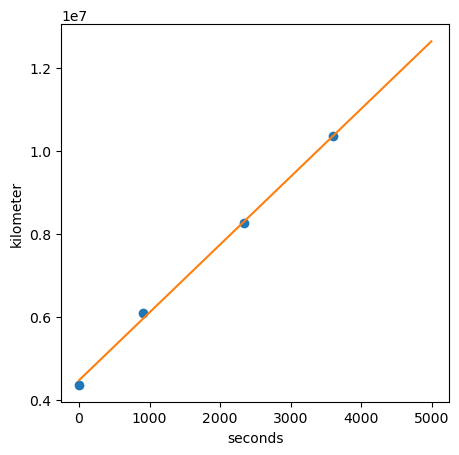

In [11]:

#done with gcs_python by J. Forstner
#on mac use: 
#>> conda activate solo
#>> gcs_gui "2017-09-06 12:48" SOHO STA -soho C3 -stereo COR2
#time!

#run 1
#gcs_gui "2020-11-29 14:00" SOHO STA -soho C3 -stereo COR2
#time 13:54 at both:
#all times 2020 Nov 29
#g1= {"time": '13:54',"half_angle": 52.11, "height": 6.32, "kappa": 0.22, "lat": -12.05, "lon": 260.0, "tilt": 90.0}
#print(g1)


g0={"time": '2020-Nov-29 13:39',"half_angle": 60.26, "height": 6.27, "kappa": 0.23, "lat": -17.05, "lon": 254.4, "tilt": 90.0}
g1={"time": '2020-Nov-29 13:54',"half_angle": 60.26, "height": 8.76, "kappa": 0.23, "lat": -17.05, "lon": 254.4, "tilt": 90.0}
g2={"time": '2020-Nov-29 14:18',"half_angle": 60.26, "height": 11.87, "kappa": 0.23, "lat": -17.05, "lon": 254.4, "tilt": 90.0}
g3={"time": '2020-Nov-29 14:39',"half_angle": 60.26, "height": 14.87, "kappa": 0.23, "lat": -17.05, "lon": 254.4, "tilt": 90.0}

gtime=[parse_time(g0['time']).datetime,parse_time(g1['time']).datetime,parse_time(g2['time']).datetime,parse_time(g3['time']).datetime]

rs=const.R_sun.value/1e3
gh_km=[np.float(g0['height'])*rs,np.float(g1['height'])*rs,np.float(g2['height'])*rs,np.float(g3['height'])*rs]

gtime_num=mdates.date2num(gtime)
gtime_sec=(gtime_num-gtime_num[0])*24*60*60

#gtime in seconds, gh in km
#print(gtime_sec,gh_km)


linfit=scipy.stats.linregress(gtime_sec,gh_km)
x_time=np.arange(0,5000,10)
y_dist=linfit.slope*x_time+linfit.intercept 

print('deprojected CME speed is', np.rint(linfit.slope),'km/s' )
print('linear fit from ',gh_km[0]/rs,' to ',gh_km[3]/rs, 'solar radii')

plt.figure(10,figsize=(5,5),dpi=100)
plt.plot(gtime_sec,gh_km,'o')
plt.plot(x_time,y_dist,'-')
plt.xlabel('seconds')
plt.ylabel('kilometer')

print('CME longitude direction is -',np.rint(360-g0['lon']))

### In situ plot Figure 3

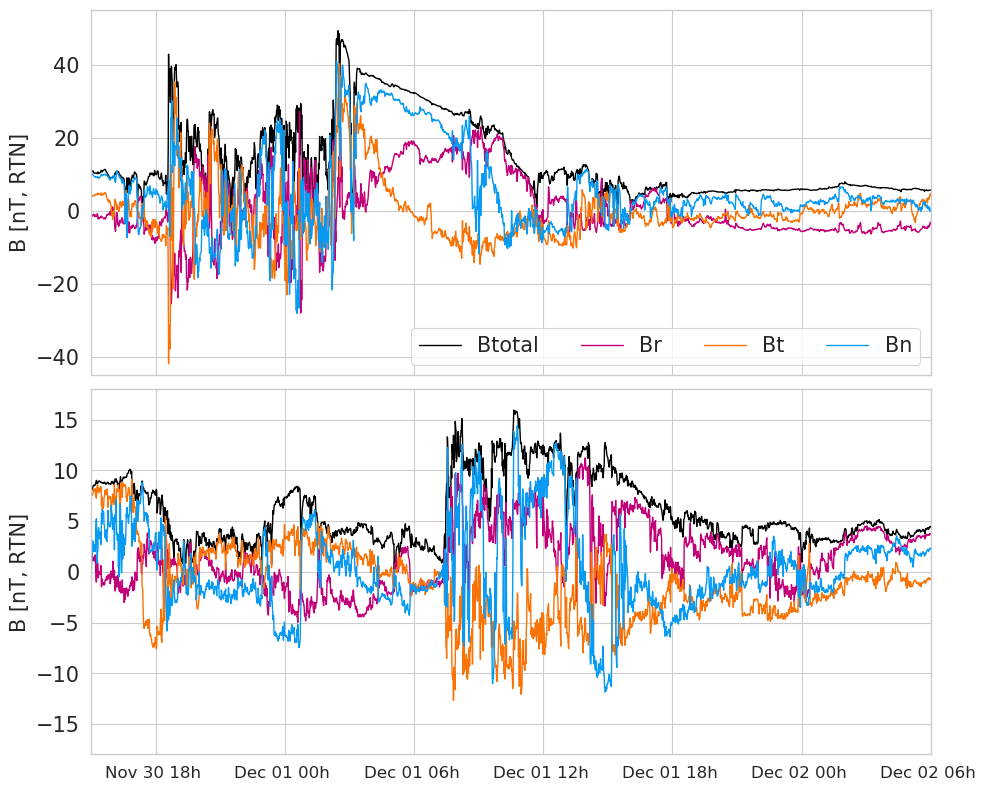

In [12]:
sns.set_style('whitegrid')
sns.set_context('paper')

plt.figure(1,figsize=(10, 8),dpi=100)

#define subplot grid
ax1 = plt.subplot2grid((2, 1), (0, 0))  
ax2 = plt.subplot2grid((2, 1), (1, 0))  

## PSP
plotstart=datetime.datetime(2020,11,30,15)
plotend=datetime.datetime(2020,12,2,6)
blim=55


ax1.plot(psp.time, psp.bt, "k-", lw=1,label='Btotal')
ax1.plot(psp.time, psp.bx, "r-", color="xkcd:magenta", lw=1, label='Br')
ax1.plot(psp.time, psp.by, "g-", color="xkcd:orange", lw=1,label='Bt')
ax1.plot(psp.time, psp.bz, "b-", color="xkcd:azure", lw=1,label='Bn')
    
#plot vertical lines
#ax1.plot_date([sicme_start_time,sicme_start_time],[-500,500],'-k',linewidth=1)            
#ax1.plot_date([smo_start_time,smo_start_time],[-500,500],'-k',linewidth=1)            
#ax1.plot_date([smo_end_time,smo_end_time],[-500,500],'-k',linewidth=1)            

ax1.set_ylabel('B [nT, RTN]',fontsize=15)
ax1.set_xlim(plotstart,plotend)
ax1.set_ylim(-blim+10,blim)
ax1.legend(loc=4,ncol=4,fontsize=15)
ax1.grid(True)
ax1.set_xticklabels([])
ax1.tick_params(axis='y', labelsize=15)
ax1.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1/4))


### STA
blim=18
ax2.plot(sta.time, sta.bt, "k-", lw=1,label='Btotal')
ax2.plot(sta.time, sta.bx, "r-", color="xkcd:magenta", lw=1, label='Br')
ax2.plot(sta.time, sta.by, "g-", color="xkcd:orange", lw=1,label='Bt')
ax2.plot(sta.time, sta.bz, "b-", color="xkcd:azure", lw=1,label='Bn')
    
ax2.set_ylabel('B [nT, RTN]',fontsize=15)
ax2.set_xlim(plotstart,plotend)
ax2.set_ylim(-blim,blim)
ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelsize=15)
#ax2.legend(loc=1,ncol=4,fontsize=15)
ax2.grid(True)
ax2.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d %Hh ') )
ax2.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1/4))

plt.tight_layout()

plt.savefig('lineups/figure_psp_sta_2020_nov_event.png')
plt.savefig('lineups/figure_psp_sta_2020_nov_event.pdf')

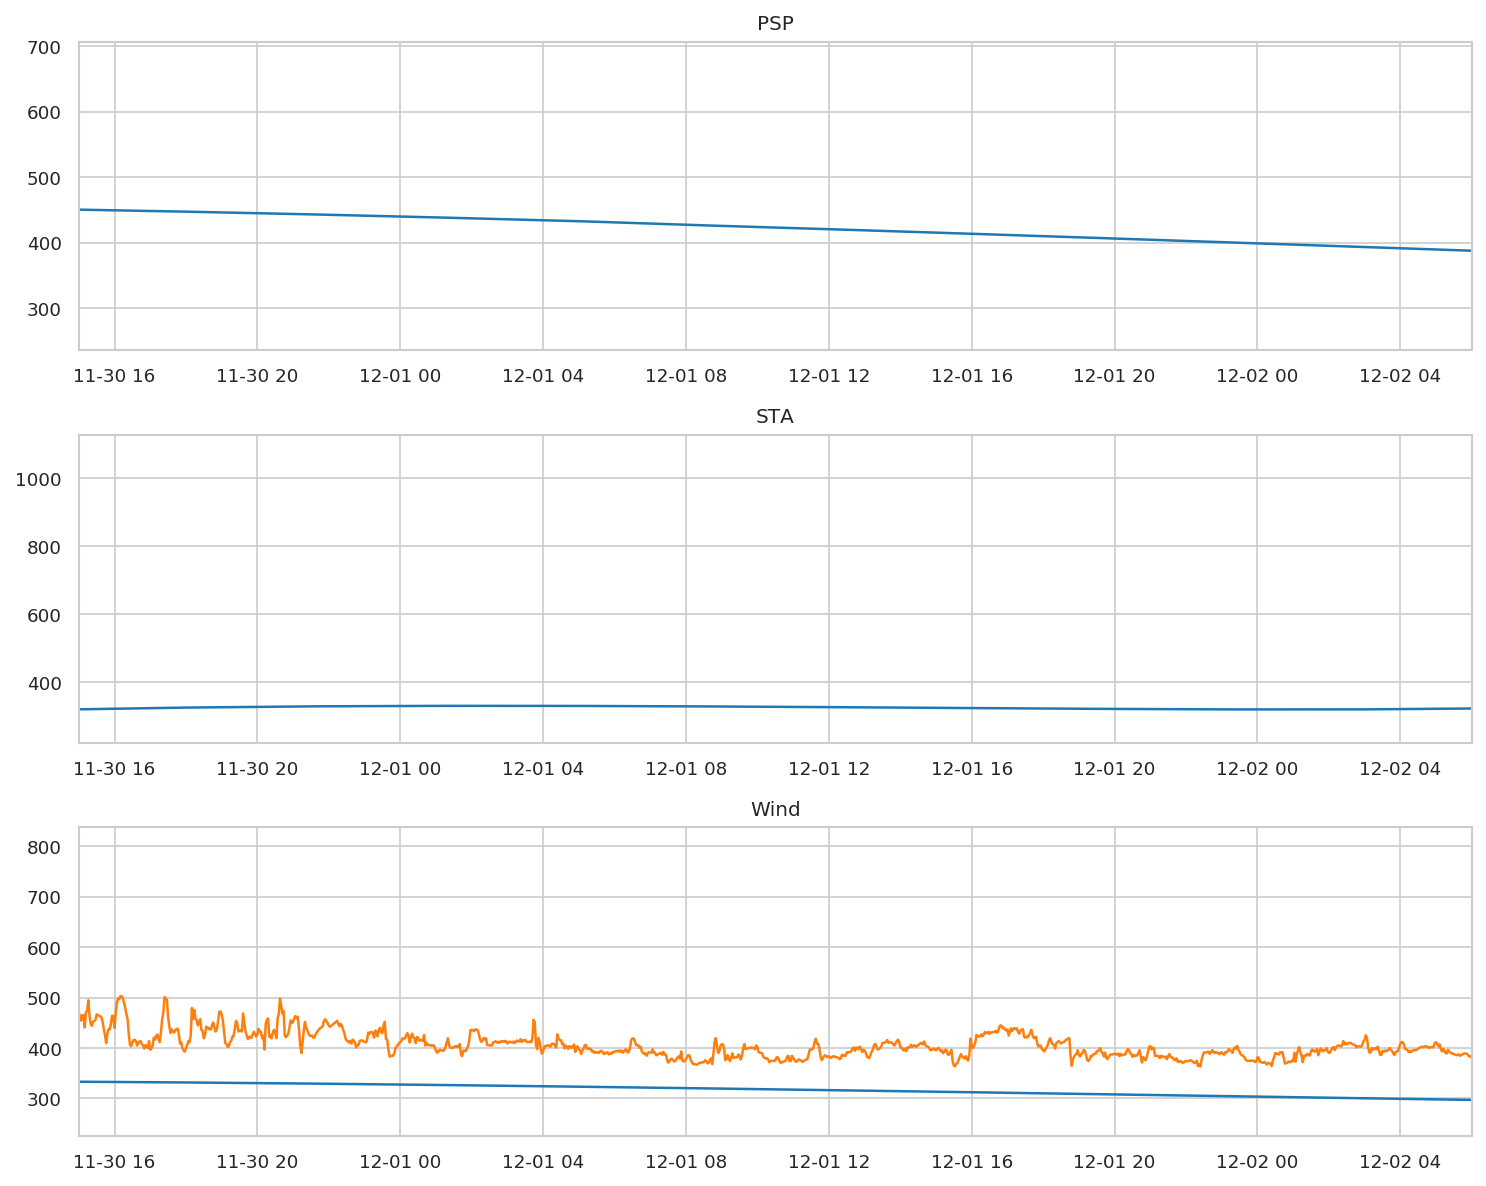

In [13]:
#check wind speed from THUX 

plt.figure(2,figsize=(10, 8),dpi=150)

#define subplot grid
ax1 = plt.subplot2grid((3, 1), (0, 0))  
ax2 = plt.subplot2grid((3, 1), (1, 0))  
ax3 = plt.subplot2grid((3, 1), (2, 0))  

ax1.plot(thux.time,thux.psp)
plotstart=datetime.datetime(2020,11,30,15)
plotend=datetime.datetime(2020,12,2,6)
ax1.set_xlim(plotstart,plotend)
ax1.set_title('PSP')

ax2.plot(thux.time,thux.sta)
ax2.set_xlim(plotstart,plotend)
ax2.plot(sta.time,sta.vt)
ax2.set_title('STA')

ax3.plot(thux.time,thux.wind)
ax3.set_xlim(plotstart,plotend)
ax3.plot(win.time,win.vt)
ax3.set_title('Wind')
plt.tight_layout()


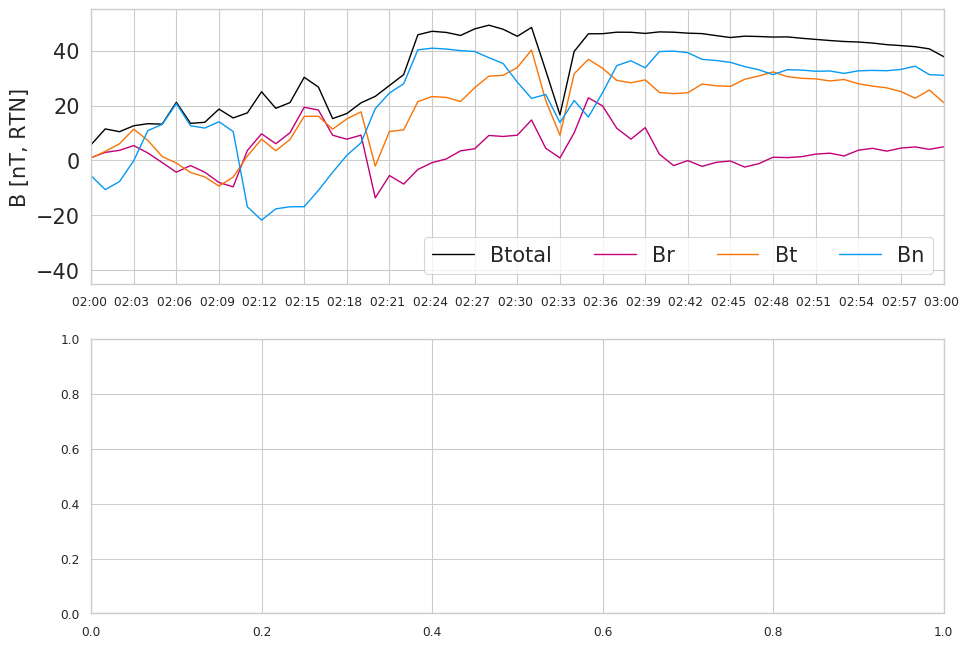

In [14]:
##close up
sns.set_style('whitegrid')
sns.set_context('paper')

plt.figure(1,figsize=(11, 8),dpi=100)

#define subplot grid
ax1 = plt.subplot2grid((2, 1), (0, 0))  
ax2 = plt.subplot2grid((2, 1), (1, 0))  

## PSP
#first shock
#plotstart=datetime.datetime(2020,11,30,18)
#plotend=datetime.datetime(2020,11,30,19)

plotstart=datetime.datetime(2020,12,1,2)
plotend=datetime.datetime(2020,12,1,3)

blim=55


ax1.plot(psp.time, psp.bt, "k-", lw=1,label='Btotal')
ax1.plot(psp.time, psp.bx, "r-", color="xkcd:magenta", lw=1, label='Br')
ax1.plot(psp.time, psp.by, "g-", color="xkcd:orange", lw=1,label='Bt')
ax1.plot(psp.time, psp.bz, "b-", color="xkcd:azure", lw=1,label='Bn')
    
#plot vertical lines
#ax1.plot_date([sicme_start_time,sicme_start_time],[-500,500],'-k',linewidth=1)            
#ax1.plot_date([smo_start_time,smo_start_time],[-500,500],'-k',linewidth=1)            
#ax1.plot_date([smo_end_time,smo_end_time],[-500,500],'-k',linewidth=1)            

ax1.set_ylabel('B [nT, RTN]',fontsize=15)
ax1.set_xlim(plotstart,plotend)
ax1.set_ylim(-blim+10,blim)
ax1.legend(loc=4,ncol=4,fontsize=15)
ax1.grid(True)
#ax1.set_xticklabels([])
ax1.tick_params(axis='y', labelsize=15)
#ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d %Hh ') )
ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M ') )
ax1.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1/(24*20)))

# June 2020 event


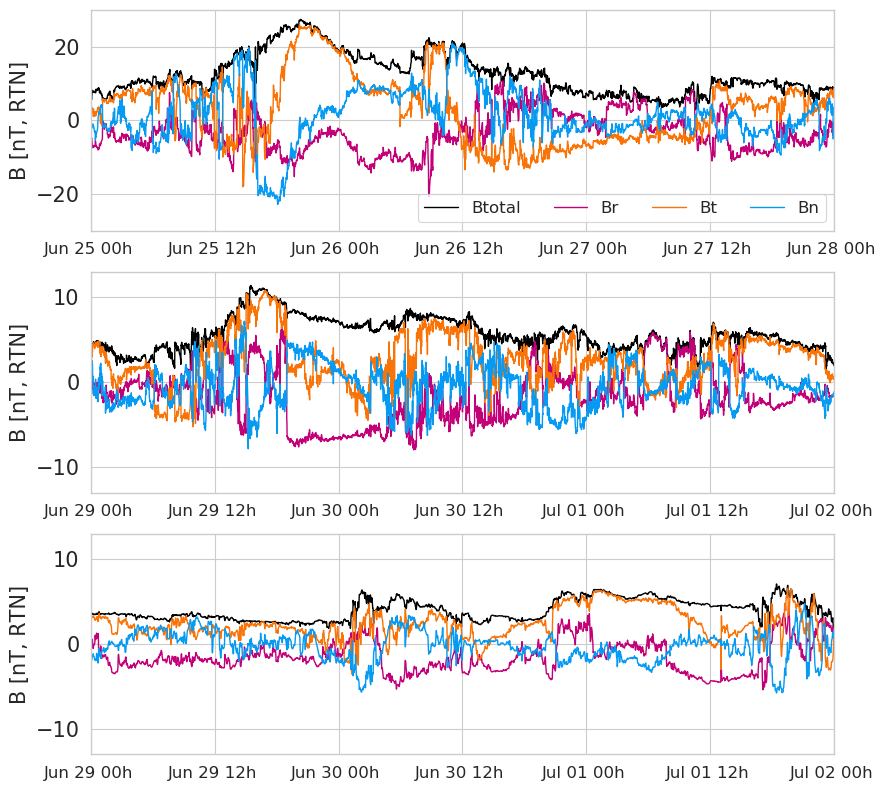

In [15]:
sns.set_style('whitegrid')
sns.set_context('paper')

plt.figure(1,figsize=(9, 8),dpi=100)

#define subplot grid
ax1 = plt.subplot2grid((3, 1), (0, 0))  
ax2 = plt.subplot2grid((3, 1), (1, 0))  
ax3 = plt.subplot2grid((3, 1), (2, 0))  



## PSP
plotstart=datetime.datetime(2020,6,25)
plotend=datetime.datetime(2020,6,28)
blim=30


ax1.plot(psp.time, psp.bt, "k-", lw=1,label='Btotal')
ax1.plot(psp.time, psp.bx, "r-", color="xkcd:magenta", lw=1, label='Br')
ax1.plot(psp.time, psp.by, "g-", color="xkcd:orange", lw=1,label='Bt')
ax1.plot(psp.time, psp.bz, "b-", color="xkcd:azure", lw=1,label='Bn')
    
#plot vertical lines
#ax1.plot_date([sicme_start_time,sicme_start_time],[-500,500],'-k',linewidth=1)            
#ax1.plot_date([smo_start_time,smo_start_time],[-500,500],'-k',linewidth=1)            
#ax1.plot_date([smo_end_time,smo_end_time],[-500,500],'-k',linewidth=1)            

ax1.set_ylabel('B [nT, RTN]',fontsize=15)
ax1.set_xlim(plotstart,plotend)
ax1.set_ylim(-blim,blim)
ax1.legend(loc=4,ncol=4,fontsize=12)
ax1.grid(True)
ax1.tick_params(axis='y', labelsize=15)
ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d %Hh ') )
ax1.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1/2))
ax1.tick_params(axis='x', labelsize=12)

### Bepi
blim=13

plotstart=datetime.datetime(2020,6,29)
plotend=datetime.datetime(2020,7,2)


ax2.plot(bepi.time, bepi.bt, "k-", lw=1,label='Btotal')
ax2.plot(bepi.time, bepi.bx, "r-", color="xkcd:magenta", lw=1, label='Br')
ax2.plot(bepi.time, bepi.by, "g-", color="xkcd:orange", lw=1,label='Bt')
ax2.plot(bepi.time, bepi.bz, "b-", color="xkcd:azure", lw=1,label='Bn')
    
ax2.set_ylabel('B [nT, RTN]',fontsize=15)
ax2.set_xlim(plotstart,plotend)
ax2.set_ylim(-blim,blim)
ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelsize=15)
#ax2.legend(loc=1,ncol=4,fontsize=15)
ax2.grid(True)
ax2.set_xticklabels([])
ax2.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d %Hh ') )
ax2.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1/2))


### Wind
blim=13
plotstart=datetime.datetime(2020,6,29)
plotend=datetime.datetime(2020,7,2)


ax3.plot(win.time, win.bt, "k-", lw=1,label='Btotal')
ax3.plot(win.time, win.bx, "r-", color="xkcd:magenta", lw=1, label='Br')
ax3.plot(win.time, win.by, "g-", color="xkcd:orange", lw=1,label='Bt')
ax3.plot(win.time, win.bz, "b-", color="xkcd:azure", lw=1,label='Bn')
    
ax3.set_ylabel('B [nT, RTN]',fontsize=15)
ax3.set_xlim(plotstart,plotend)
ax3.set_ylim(-blim,blim)
ax3.tick_params(axis='x', labelsize=12)
ax3.tick_params(axis='y', labelsize=15)
#ax2.legend(loc=1,ncol=4,fontsize=15)
ax3.grid(True)
ax3.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d %Hh ') )
ax3.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1/2))

plt.tight_layout()


plt.savefig('lineups/figure_2020_june_event.png')
plt.savefig('lineups/figure_2020_june_event.pdf')



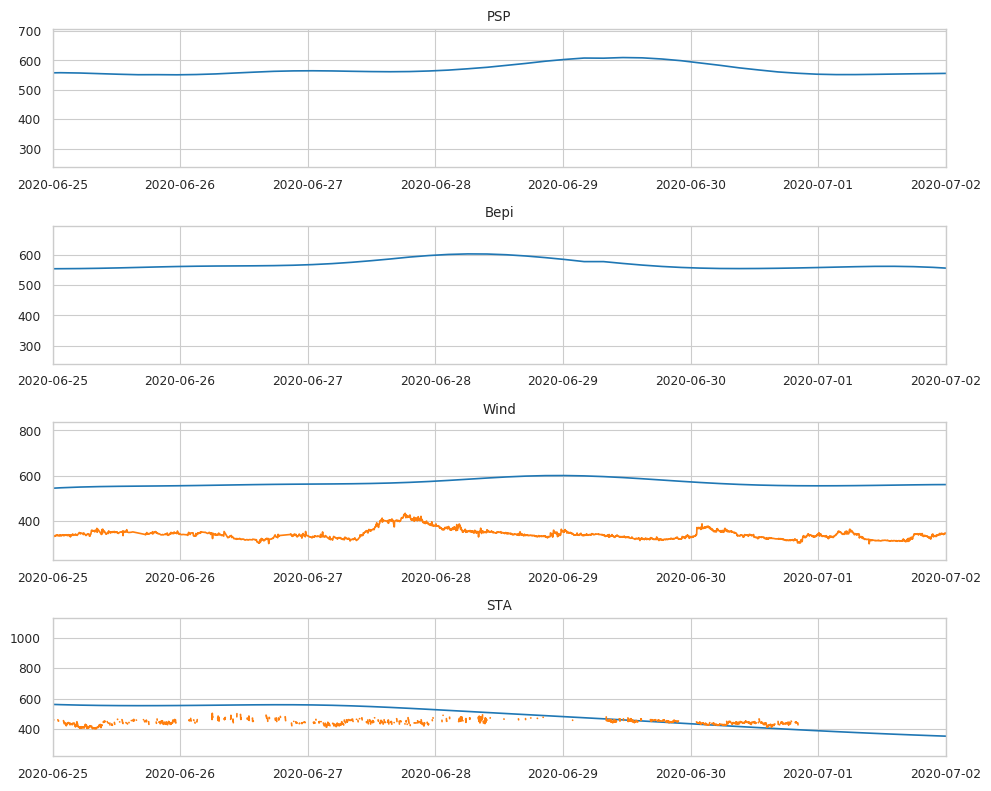

In [16]:
#check wind speed from THUX 

plt.figure(2,figsize=(10, 8),dpi=100)

#define subplot grid
ax1 = plt.subplot2grid((4, 1), (0, 0))  
ax2 = plt.subplot2grid((4, 1), (1, 0))  
ax3 = plt.subplot2grid((4, 1), (2, 0))  
ax4 = plt.subplot2grid((4, 1), (3, 0))  



ax1.plot(thux.time,thux.psp)
plotstart=datetime.datetime(2020,6,25)
plotend=datetime.datetime(2020,7,2)
ax1.set_xlim(plotstart,plotend)
ax1.set_title('PSP')

ax2.plot(thux.time,thux.bepi)
ax2.set_xlim(plotstart,plotend)
ax2.set_title('Bepi')

ax3.plot(thux.time,thux.wind)
ax3.set_xlim(plotstart,plotend)
ax3.plot(win.time,win.vt)
ax3.set_title('Wind')

ax4.plot(thux.time,thux.sta)
ax4.set_xlim(plotstart,plotend)
ax4.plot(sta.time,sta.vt)
ax4.set_title('STA')

plt.tight_layout()
